# Predictive Analysis of AirBnb room listings 2019 

Dataset: 
    This dataset is about the listing activity and metrics in NYC for 2019. Since 2008, guests and hosts have used Airbnb to expand on traveling possibilities and present more unique, personalized way of experiencing the world. this dataset is obtained from kaggle. 
    In this dataset, we have around 49000 entries and 16 different features. We will initially see if our dataset is having any null values. For this project, we have decided to perform different steps in model building, like data analysis, data visualization and data modelling. 

The main objective of this project is to predict the no. of nights for which a particular room will be available if all other information is given. We will try to see how we can implement different models like linear, lasso, decision tree, neural network, gradient boosting and random forest.  


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import utils
import os 
os.getcwd()


'/Users/avinashtripathi'

In [4]:
os.chdir('/Users/avinashtripathi/Downloads')
df = pd.read_csv("AB_NYC_2019.csv")
print(df.head())

     id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  20

# Cleaning of Data

In [6]:
print(df.isnull().sum()) #Fing all the null values in the data

#Since only 16 values are null, we would be using forward and backward filling respectively.
df["name"] = df["name"].fillna(method = "ffill")
df["host_name"] = df["host_name"].fillna(method = "bfill")

#Since, it has decimal values, we would be using mean of the column to fillup the values.
df["reviews_per_month"] = df["reviews_per_month"].fillna(df["reviews_per_month"].mean())

#dropping columns that are not significant or could be unethical to use for our future data exploration and predictions
#We are removing last review becasue of too many unknown variables and it is a data time type, 
#Hence, it would be difficult to predict 10052 values in this column.
df.drop(["name","host_name","id","last_review"], axis = 1, inplace = True)


#Dimensions of data
print('Rows     :',df.shape[0])
print('Columns  :',df.shape[1])
print('\nFeatures :\n     :',df.columns.tolist())

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64
Rows     : 48895
Columns  : 12

Features :
     : ['host_id', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']


# Data Visualisation

Placements of the Hotels

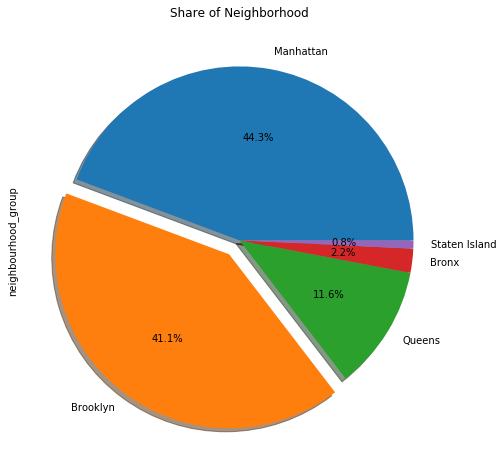

In [7]:
plt.figure(figsize=(8,8))
df['neighbourhood_group'].value_counts().plot.pie(explode=[0,0.1,0,0,0],autopct='%1.1f%%',shadow=True)
plt.title('Share of Neighborhood')
plt.show()

Spread of Hotels according to latitude and longitude

AttributeError: module 'seaborn' has no attribute 'plt'

<Figure size 1080x864 with 0 Axes>

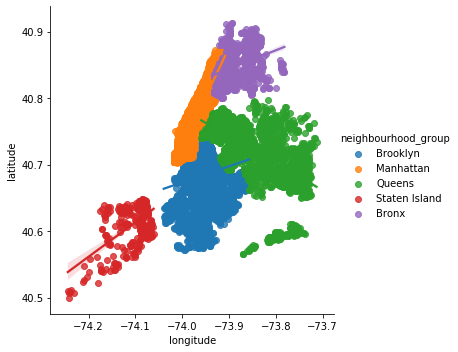

In [8]:
#colors = df["neighbourhood_group"].unique().count()
plt.figure(figsize=(15,12))
sns.lmplot(x = "longitude", y = "latitude",hue = "neighbourhood_group", data = df)
#plt.scatter(df.longitude,df.latitude, c = colors)
sns.plt.show()

Variations of prices of hotels with area

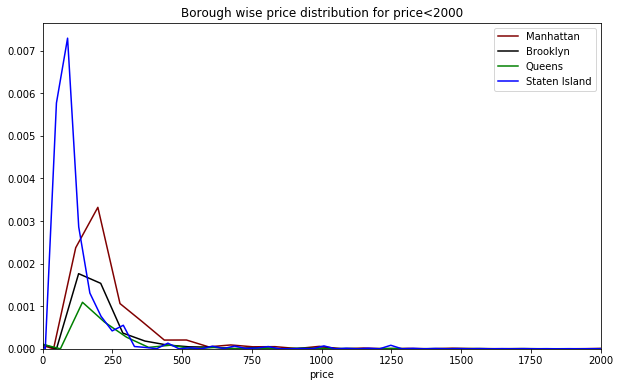

In [9]:
plt.figure(figsize=(10,6))
sns.distplot(df[df.neighbourhood_group=='Manhattan'].price,color='maroon',hist=False,label='Manhattan')
sns.distplot(df[df.neighbourhood_group=='Brooklyn'].price,color='black',hist=False,label='Brooklyn')
sns.distplot(df[df.neighbourhood_group=='Queens'].price,color='green',hist=False,label='Queens')
sns.distplot(df[df.neighbourhood_group=='Staten Island'].price,color='blue',hist=False,label='Staten Island')
plt.title('Borough wise price distribution for price<2000')
plt.xlim(0,2000)
plt.show()

Boxplot showing price variation

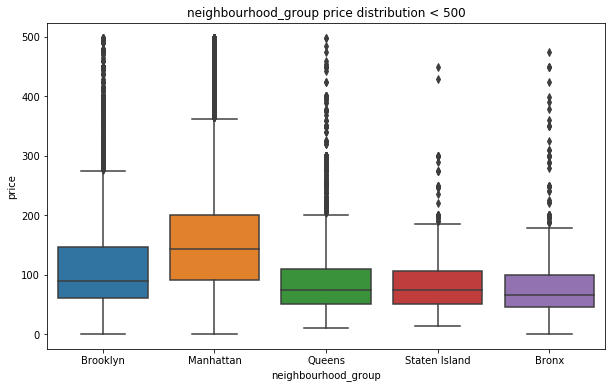

In [10]:
ng = df[df.price <500]
plt.figure(figsize=(10,6))
sns.boxplot(y="price",x ='neighbourhood_group' ,data = ng)
plt.title("neighbourhood_group price distribution < 500")
plt.show()

Type of Rooms:

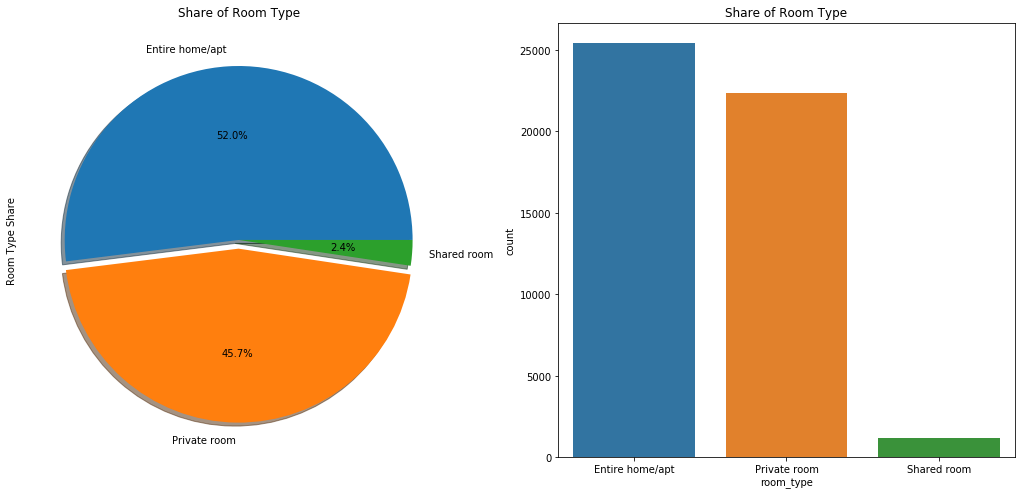

In [11]:
f,ax=plt.subplots(1,2,figsize=(18,8))
df['room_type'].value_counts().plot.pie(explode=[0,0.05,0],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Share of Room Type')
ax[0].set_ylabel('Room Type Share')
sns.countplot('room_type',data=df,ax=ax[1],order=df['room_type'].value_counts().index)
ax[1].set_title('Share of Room Type')
plt.show()

Rooms Vs Neighbourhood_Group

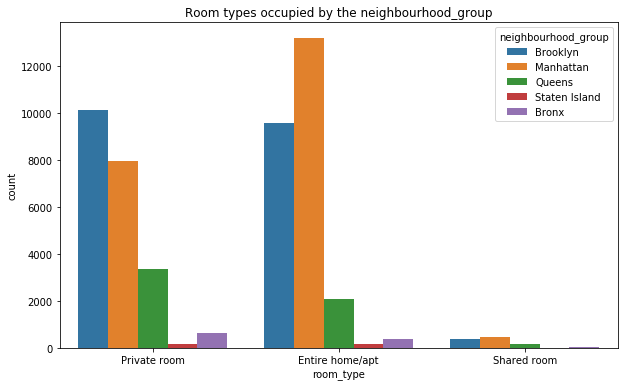

In [12]:
plt.figure(figsize=(10,6))
sns.countplot(x = 'room_type',hue = "neighbourhood_group",data = df)
plt.title("Room types occupied by the neighbourhood_group")
plt.show()

Distribution of Room_Availability and minimum number of nights:

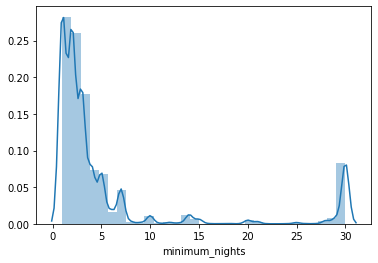

In [13]:
sns.distplot(df[(df['minimum_nights'] <= 30) & (df['minimum_nights'] > 0)]['minimum_nights'], bins=31)
plt.show()

# Feature Selection

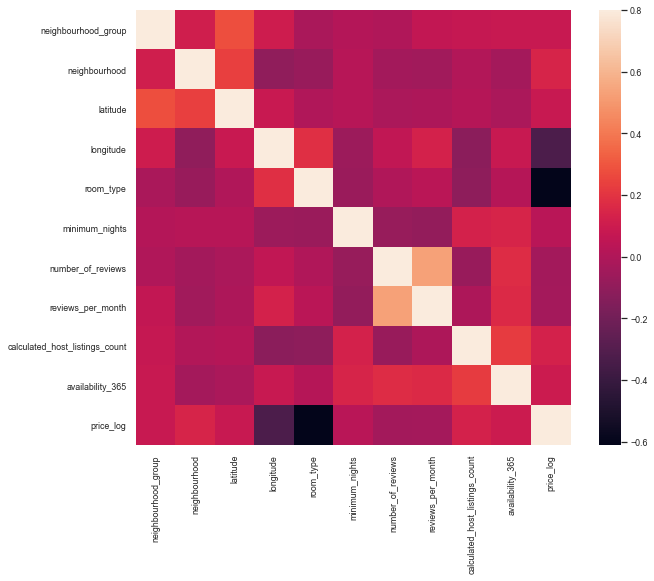

In [15]:
corrmatrix = df.corr()
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corrmatrix, vmax=0.8, square=True)
sns.set(font_scale=0.8)

# Data Preprocessing

In [16]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import scale, StandardScaler, RobustScaler

#Handling Categorical Variables
df['neighbourhood_group']= df['neighbourhood_group'].astype("category").cat.codes
df['neighbourhood'] = df['neighbourhood'].astype("category").cat.codes
df['room_type'] = df['room_type'].astype("category").cat.codes
df['price_log'] = np.log(df.price+1)

#dropping output
df.drop(['host_id','price'], axis=1, inplace=True)
    
nyc_model_x, nyc_model_y = df.iloc[:,:-1], df.iloc[:,-1]
scaler = StandardScaler()
nyc_model_x = scaler.fit_transform(nyc_model_x)


X_train, X_test, y_train, y_test = train_test_split(nyc_model_x, nyc_model_y, test_size=0.3, random_state=101)

print(utils.multiclass.type_of_target(X_train))
utils.multiclass.type_of_target(y_train.astype("int"))
print(utils.multiclass.type_of_target(X_test))
utils.multiclass.type_of_target(y_test.astype("int"))

AttributeError: 'DataFrame' object has no attribute 'price'

# Let's apply few ML models to see how well they are able to predict price when number of nights are given:

1. PCA and Linear Regression 

In [17]:
#PCA and Linear Regression Implmentation
from sklearn.decomposition import PCA

pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

explained_variance = pca.explained_variance_ratio_
print(explained_variance)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

from sklearn.linear_model import LinearRegression

classifier = LinearRegression()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)
utils.multiclass.type_of_target(y_pred.astype("int"))

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

print("---------------------Linear Regression Algorithm-----------------------------")
print("""
        Mean Squared Error: {}
        R2 Score: {}
        Mean Absolute Error: {}
     """.format(
        np.sqrt(mean_squared_error(y_test, y_pred)),
        r2_score(y_test,y_pred),
        mean_absolute_error(y_test,y_pred)
        ))

[0.17286369 0.14998776 0.13619879 0.11724431 0.08880786 0.08132037
 0.07396105 0.07080136 0.0648573  0.04395751]
---------------------Linear Regression Algorithm-----------------------------

        Mean Squared Error: 0.6579060599727712
        R2 Score: 0.11145095002378147
        Mean Absolute Error: 0.5082893220481227
     


2. LASSO Regression

In [18]:

from sklearn.linear_model import Lasso
def lasso_reg(input_x, input_y, cv=5):
    ## Defining parameters
    model_Lasso= Lasso()

    # prepare a range of alpha values to test
    alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
    normalizes= ([True,False])

    ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.

    grid_search_lasso = GridSearchCV(estimator=model_Lasso,  
                         param_grid=(dict(alpha=alphas, normalize= normalizes)),
                         scoring='neg_mean_squared_error',
                         cv=cv,
                         n_jobs=-1)

    ## Lastly, finding the best parameters.

    grid_search_lasso.fit(input_x, input_y)
    best_parameters_lasso = grid_search_lasso.best_params_  
    best_score_lasso = grid_search_lasso.best_score_ 
    print(best_parameters_lasso)
    print(best_score_lasso)

kfold_cv=KFold(n_splits=5, random_state=42, shuffle=False)
for train_index, test_index in kfold_cv.split(nyc_model_x,nyc_model_y):
    X_train, X_test = nyc_model_x[train_index], nyc_model_x[test_index]
    y_train, y_test = nyc_model_y[train_index], nyc_model_y[test_index]

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score
Lasso_model = Lasso(alpha = 0.001, normalize =False)
Lasso_model.fit(X_train, y_train)
pred_Lasso = Lasso_model.predict(X_test)
print('------------------Phase-1 LASSO-----------------------------')
print("""
        Mean Squared Error: {}
        R2 Score: {}
        Mean Absolute Error: {}
     """.format(
        np.sqrt(mean_squared_error(y_test, pred_Lasso)),
        r2_score(y_test,pred_Lasso),
        mean_absolute_error(y_test,pred_Lasso)
        ))

------------------Phase-1 LASSO-----------------------------

        Mean Squared Error: 0.5385499777404319
        R2 Score: 0.49727723915907684
        Mean Absolute Error: 0.3909164418410697
     


/Users/avinashtripathi/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


3. Gradient Boosting Algorithm

In [19]:
from sklearn.ensemble import  GradientBoostingRegressor
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.01)
GBoost.fit(X_train,y_train)

predicts2 = GBoost.predict(X_test)

print("---------------------Gradient Boosting---------------------------")
print("""
        Mean Squared Error: {}
        R2 Score: {}
        Mean Absolute Error: {}
     """.format(
        np.sqrt(mean_squared_error(y_test, predicts2)),
        r2_score(y_test,predicts2),
        mean_absolute_error(y_test,predicts2)
        ))

---------------------Gradient Boosting---------------------------

        Mean Squared Error: 0.4871333780294031
        R2 Score: 0.5886871287499774
        Mean Absolute Error: 0.36232993523411205
     


4.RandomForest Algorithm

In [20]:
#RandomForest Algorithm
from sklearn.ensemble import RandomForestRegressor
model_name = "Random Forest Regressor"

model_random = RandomForestRegressor(n_estimators = 100, max_depth=15, random_state = 42)
model_random.fit(X_train, y_train)

y_pred_3 = model_random.predict(X_test)
print("----------------Random Forest Algorithm-----------------------")
print("""
        Mean Squared Error: {}
        R2 Score: {}
        Mean Absolute Error: {}
     """.format(
        np.sqrt(mean_squared_error(y_test, y_pred_3)),
        r2_score(y_test,y_pred_3),
        mean_absolute_error(y_test, y_pred_3)
        ))

----------------Random Forest Algorithm-----------------------

        Mean Squared Error: 0.5158293530587795
        R2 Score: 0.538800712622023
        Mean Absolute Error: 0.37817756856961876
     


5. Neural Netwrok Implementation

In [21]:
from sklearn.neural_network import MLPRegressor

regressor = MLPRegressor(hidden_layer_sizes = (100, 75, 50, 25), activation = 'relu', solver = 'sgd',
                                 learning_rate = 'adaptive', alpha = 0.01, random_state = 101)
regressor.fit(X_train, y_train)
#print(regressor.loss_)

y_pred_4 = regressor.predict(X_test)
print("------------------Neural Network----------------------------")
print("""
        Mean Squared Error: {}
        R2 Score: {}
        Mean Absolute Error: {}
     """.format(
        np.sqrt(mean_squared_error(y_test, y_pred_4)),
        r2_score(y_test,y_pred_4),
        mean_absolute_error(y_test,y_pred_4)
        ))

------------------Neural Network----------------------------

        Mean Squared Error: 0.49334005296031147
        R2 Score: 0.5781390988148302
        Mean Absolute Error: 0.36622000741829847
     


6. Decision Tree Algorithm

In [22]:
from sklearn.tree import DecisionTreeRegressor

decision_model = DecisionTreeRegressor(random_state = 0, max_depth = 10)
decision_model.fit(X_train, y_train)

y_pred_5 = decision_model.predict(X_test)
print("------------------Decision Trees----------------------------")
print("""
        Mean Squared Error: {}
        R2 Score: {}
        Mean Absolute Error: {}
     """.format(
        np.sqrt(mean_squared_error(y_test, y_pred_5)),
        r2_score(y_test,y_pred_5),
        mean_absolute_error(y_test,y_pred_5)
        ))

------------------Decision Trees----------------------------

        Mean Squared Error: 0.556989105127388
        R2 Score: 0.4622629943436656
        Mean Absolute Error: 0.3959529839305705
     


# Conclusion:
To clean our dataset, I preformed forward and backword filling. In order to fill the Null values for the numerical datatype, filled the cells by the mean value, which was calculated based on the available data.

In the data visualization part, I analysed different plots like Placements of the Hotels, Variations of prices of hotels with area, Boxplot showing price variation, Type of Rooms, Rooms Vs Neighbourhood Group, Distribution of Room Availability and minimum number of nights. I also gained insights like how the room distribution is as per different boroughs and what kind of prices can you expect in which area.

After that I moved onto the analysis of different models, segregated our dataset in training and testing and then checked how well our model is performing with respect to testing dataset. For the comparison, and to see how well our model is at predictions, I took different parameters into consideration like R2, mean square error and mean absolute error. 

Table 2. R2 ,MSE and MAE for different models

Models	Linear 	Lasso 	Gradient boosting 	Random Forest 	Neural Network 	Decision Tree 
R2	     0.111	0.488	0.588	            0.538	        0.538	        0.578
MSE	     0.657	0.543	0.487	            0.515	        0.515	        0.493
MAE 	 0.508	0.317	0.362	            0.378	        0.378	        0.366

From the above table we can say that for this particular dataset, Gradient boosting is somewhat better than the other modelling techniques. 

I can further implement additional modification for our model like decision tree, neural network. To improve their performance. Like increasing the number of hidden layers or if we can include the dropout layer for the decision tree we may get some other model as the best one. But with the components that we currently took into consideration we found out that gradient boosting is the best option.
